## Anotation Conversion Function

In [2]:
# import the necessary packages

import os
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob

In [3]:

# Function to create masked images from annotations 

def create_masked_images(image_dir, annotation_dir, masks_dir):
    # Ensure the masks directory exists
    os.makedirs(masks_dir, exist_ok=True)

    # List all image files in the image directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    for img_file in image_files:
        # Construct paths for each image and annotation file
        img_path = os.path.join(image_dir, img_file)
        annotation_file = os.path.join(annotation_dir, os.path.splitext(img_file)[0] + '.json')

        # Load annotations from JSON file
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        # Initialize main image
        main_image = Image.open(img_path)
        img_width, img_height = main_image.size

        # Initialize images for annotations and mask
        img_annotations = Image.new('RGB', (img_width, img_height), (255, 255, 255))  # White background for annotations
        img_mask = Image.new('L', (img_width, img_height), 255)  # White background for mask
        draw_annotations = ImageDraw.Draw(img_annotations)
        draw_mask = ImageDraw.Draw(img_mask)

        # Extract and process segmentation data
        items_found = [item for item in annotations.keys() if item.startswith('item')]
        for item_key in items_found:
            item_annotations = annotations[item_key]["segmentation"]
            for polygon in item_annotations:
                points = [(x, y) for x, y in zip(polygon[0::2], polygon[1::2])]  # Convert flat list to (x, y) pairs
                draw_annotations.polygon(points, outline=(255, 0, 0), fill=(255, 0, 0))  # Red color for item on annotations
                draw_mask.polygon(points, outline=0, fill=0)

        # Save the masked image with the same filename + '_masked'
        masked_image_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '_masked.jpg')
        img_mask.save(masked_image_path)

        print(f"Saved masked image: {masked_image_path}")



In [6]:

# Define directories
dataset_dir = r'C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data'
image_dir = os.path.join(dataset_dir, 'pictures')
annotation_dir = os.path.join(dataset_dir, 'annotation')
masks_dir = os.path.join(dataset_dir, 'masks')

# Create masked images
create_masked_images(image_dir, annotation_dir, masks_dir)

Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000001_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000002_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000003_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000004_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000005_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000006_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000007_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000008_masked.jpg
Saved masked image: C:\Users\AHMED OSAMA\Desktop\code\computer vision\lectures\data\masks\000009_masked.jpg
Saved masked image: C:\Users

In [4]:


# Function to load images and masks
def load_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0
    
    return img, mask

# Get lists of image and mask paths
image_paths = glob(os.path.join(image_dir, '*.jpg'))
mask_paths = glob(os.path.join(masks_dir, '*_masked.jpg'))

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(lambda img, mask: load_image(img, mask), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# print the shape of the first batch
for images, masks in dataset.take(1):
    print(images.shape, masks.shape)


(32, 256, 256, 3) (32, 256, 256, 1)


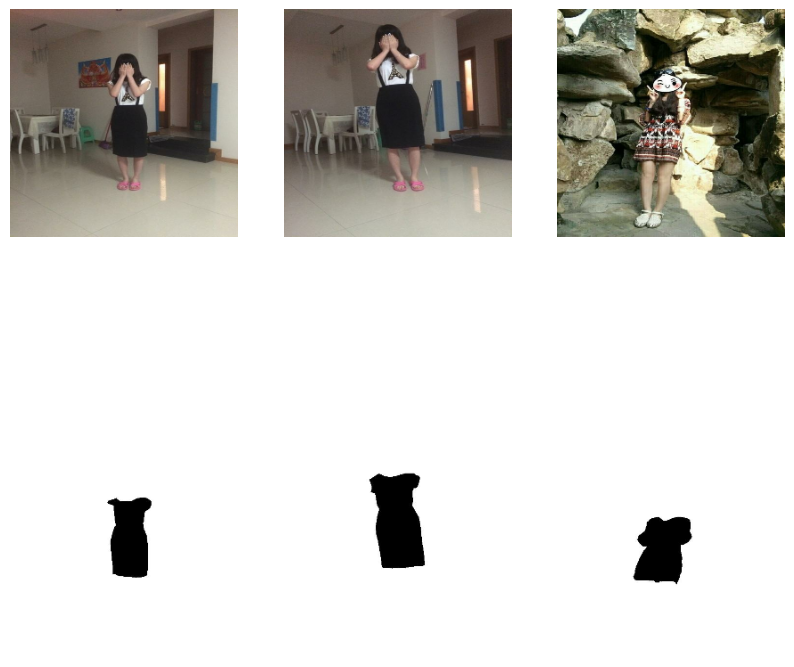

In [6]:

# Display some sample images and masks from the dataset
def display_sample_data(dataset, num_samples=3):
    plt.figure(figsize=(10, 10))
    for images, masks in dataset.take(1):
        for i in range(num_samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.axis('off')
    plt.show()

display_sample_data(dataset)